In [1]:
from fastai.vision import * #import from vision to use the classification interpreter
from pathlib import Path
import pdb
import seaborn as sns
from scipy.signal import resample
from sklearn.decomposition import PCA
path = Path("earthquake")
from timeseries import TimeSeriesItem, TimeSeriesList, UCRArchive

In [110]:
trainDF = pd.read_csv(path/"train.csv",dtype={"acoustic_data": np.float32, "time_to_failure": np.float32})

KeyboardInterrupt: 

In [2]:
trainDF = pd.read_feather(path/"eq.feather")

C:\Users\lordn\Anaconda3\envs\fastai\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


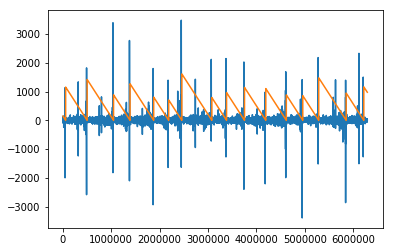

In [3]:
sample_freq = 100
plt.plot(trainDF.acoustic_data.values[::sample_freq])
plt.plot(trainDF.time_to_failure.values[::sample_freq]*100)

In [4]:
def extract_features(z):
    return np.c_[
        z.mean(axis=1), 
        np.percentile(np.abs(z), q=[0, 25, 50, 75, 100], axis=1).T, 
        z.std(axis=1)
    ]

In [5]:
def create_X(x, window_size=1000, sequence_len=150):
    tmp = x.reshape(sequence_len, -1)
    return np.c_[
        extract_features(tmp),
        extract_features(tmp[:, -window_size // 10:]),
        extract_features(tmp[:, -window_size // 100:])
    ]

In [6]:
def processDF(df,window_size=1000,sequence_len=150):
    rows = df.shape[0] // (window_size*sequence_len)
    data, labels = [], []
    for segment in range(rows):
        seg = df.iloc[segment*window_size*sequence_len: (segment+1)*window_size*sequence_len]
        x = seg.acoustic_data.values
        y = seg.time_to_failure.values[-1]
        data.append(create_X(x,window_size,sequence_len))
        labels.append(y)
    return np.stack(data),np.stack(labels)

In [7]:
x,y = processDF(trainDF)

In [4]:
x = trainDF.acoustic_data.values
c = len(x) - (len(x) % 150000)
x = x[:c]
y = trainDF.time_to_failure.values[:c]
x = x.reshape(-1,150000)
y = y.reshape(-1,150000)
y = y[:,-1]

In [52]:
testX = []
testL = []
for f in progress_bar(list((path/"test").glob("*.csv"))):
    seg_id = f.name[:-4]
    testL.append(seg_id)
    df = pd.read_csv(f,dtype={"acoustic_data": np.float32})
    x = df.acoustic_data.values
    testX.append(create_X(x))
    
testX = np.stack(testX)

In [10]:
dataTest = (TimeSeriesList.from_numpy(testX)
                          .no_split()
                          .label_from_list(testL)
                          .databunch(bs=32,num_workers=0))

NameError: name 'testX' is not defined

In [8]:
n_features = create_X(trainDF.acoustic_data.values[0:150000]).shape[1]

In [11]:
class NormalizeTS(PreProcessor):
    def process(self,ds):
        mean, std = ds.items.mean(axis=1,keepdims=True), ds.items.std(axis=1,keepdims=True)
        ds.items = mean + std * ds.items
        
    def process_one(self,item):
        mean, std = item.mean(),item.std()
        return mean + item / std 

In [9]:
data = (TimeSeriesList.from_numpy(x)
                      .random_split_by_pct()
                      .label_from_list(y)
                      .databunch(bs=16,num_workers=0))

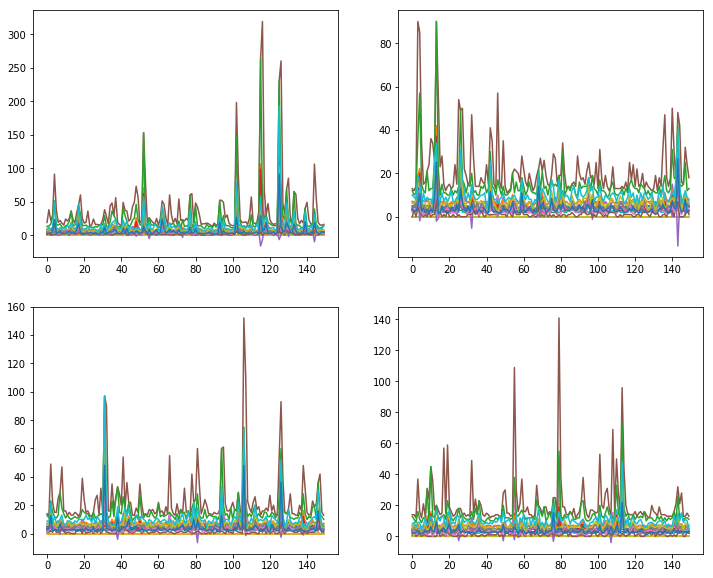

In [10]:
data.show_batch()

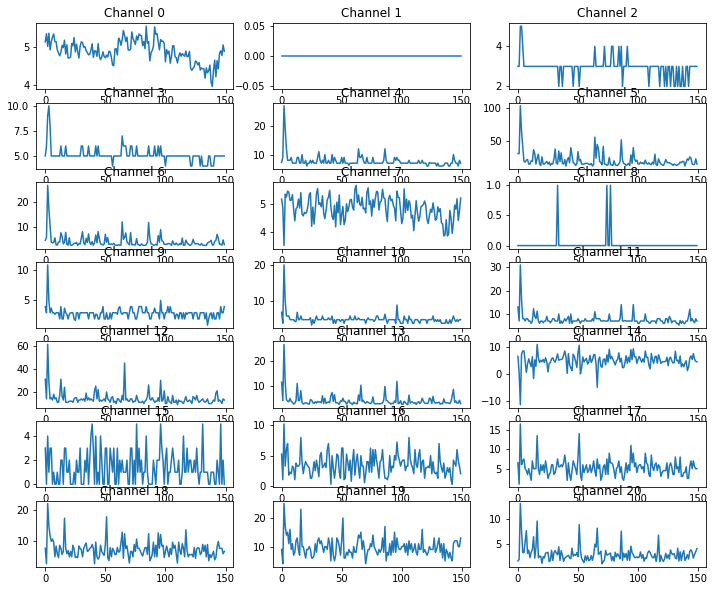

In [12]:
data.x[0].show_channels()

In [15]:
class BasicLSTM(torch.nn.Module):
    def __init__(self,n_features):
        super().__init__()
        self.rnn = torch.nn.LSTM(n_features,200,2,batch_first=True)
        self.out = torch.nn.Linear(200,1)
        
    def forward(self,ts):
        output,_ = self.rnn(ts)
        return torch.sigmoid(self.out(output[:,-1]).squeeze(-1)) * 20.0

In [41]:
class EQClassifier(torch.nn.Module):
    def __init__(self,n_features,maxY=20.0):
        super().__init__()
        self.maxY =  maxY
        self.conv = WideResNet1d(3,3,6,n_features=n_features,start_nf=48)
        self.out = torch.nn.Linear(self.conv.nf,1)
        
    def forward(self,ts):
        ts = self.conv(ts.transpose(1,2))
        return torch.sigmoid(self.out(ts).squeeze(-1)) * self.maxY

In [42]:
def mean_absolute_error(pred:Tensor, targ:Tensor)->Rank0Tensor:
    return torch.abs(pred-targ).mean()

In [43]:
minY,maxY = [f(data.train_ds.y.items) for f in [min,max]]

In [44]:
#model=BasicLSTM(n_features)
model = EQClassifier(n_features)
learn = Learner(data,model,loss_func=F.mse_loss,metrics=[mean_absolute_error])

In [45]:
learn.model(next(iter(data.train_dl))[0]).size()

torch.Size([16])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


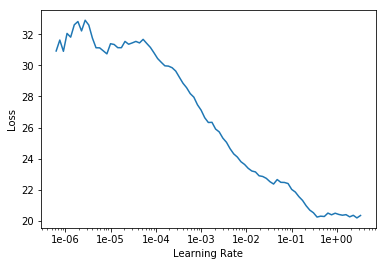

In [28]:
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,mean_absolute_error
1,14.295401,16.853092,3.343584
2,14.047566,13.780833,3.086171
3,13.643640,13.396686,3.063792
4,12.995693,13.627875,3.077598
5,13.590122,14.078562,3.111489
6,13.268183,14.182437,3.120651
7,12.731467,14.217462,3.125467
8,13.222091,13.560375,3.075774
9,13.142313,13.542218,3.072961
10,12.776139,13.632312,3.081637


In [62]:
learnTest = Learner(dataTest,model,loss_func=F.mse_loss)

In [64]:
preds,lbl = learnTest.get_preds(DatasetType.Train)

In [71]:
lbl = [dataTest.y.classes[l.item()] for l in lbl]

In [74]:
preds = preds.tolist()

In [78]:
testOutDF = pd.DataFrame({"seg_id": lbl,"time_to_failure":preds})
testOutDF.head()

,seg_id,time_to_failure
0,seg_5f352e,5.767172
1,seg_fde86d,6.472018
2,seg_e067ab,6.798669
3,seg_d6dad6,6.399252
4,seg_cc096e,6.832201


In [79]:
testOutDF.to_csv(path/"out.csv",index=False)

In [71]:
dataAE = (TimeSeriesList.from_numpy(x)
                      .no_split()
                      .label_from_list(x[:,:,0],label_cls=TimeSeriesList)
                      .databunch(bs=32,num_workers=0))

In [72]:
dataAE.one_batch()[1].shape

torch.Size([32, 150])

In [73]:
class EQAE(torch.nn.Module):
    def __init__(self,n_features,seqLen):
        super().__init__()
        self.conv = WideResNet1d(3,3,6,n_features=n_features,start_nf=48)
        self.mean = torch.nn.Linear(self.conv.nf,100)
        self.logvar = torch.nn.Linear(self.conv.nf,100)

        layers = []
        for a,b in [(100,200),(200,300),(300,400)]:
            layers += bn_drop_lin(a,b,actn=torch.nn.ReLU())
        self.lin = torch.nn.Sequential(*layers)
        self.out = torch.nn.Linear(400,seqLen)
        
    def forward(self,ts):
        seqLen = ts.shape[1]
        ts = self.conv(ts.transpose(1,2))
        mean, logvar = self.mean(ts), self.logvar(ts)
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        ls = eps.mul(std).add_(mean)
        
        return self.out(self.lin(ls)), mean, logvar

In [74]:
class VAELoss(torch.nn.Module):
    def forward(self,p,target):
        pred,mean,logvar = p
        self.mse = torch.nn.functional.mse_loss(pred,target,reduction="sum")
        self.kld = -0.5 * torch.sum(1+logvar-mean.pow(2)-logvar.exp())
        return self.mse + self.kld

In [75]:
learnAE = Learner(dataAE,EQAE(n_features,150),loss_func=VAELoss())

In [76]:
learnAE.model(dataAE.one_batch()[0].cuda())[0].size()

torch.Size([32, 150])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


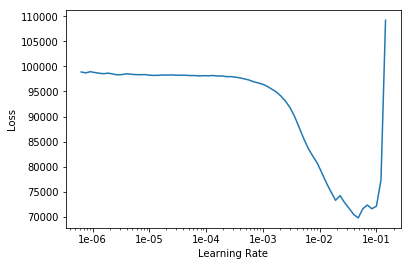

In [77]:
learnAE.lr_find()
learnAE.recorder.plot()

In [80]:
learnAE.fit_one_cycle(10,1e-2,wd=0.2)

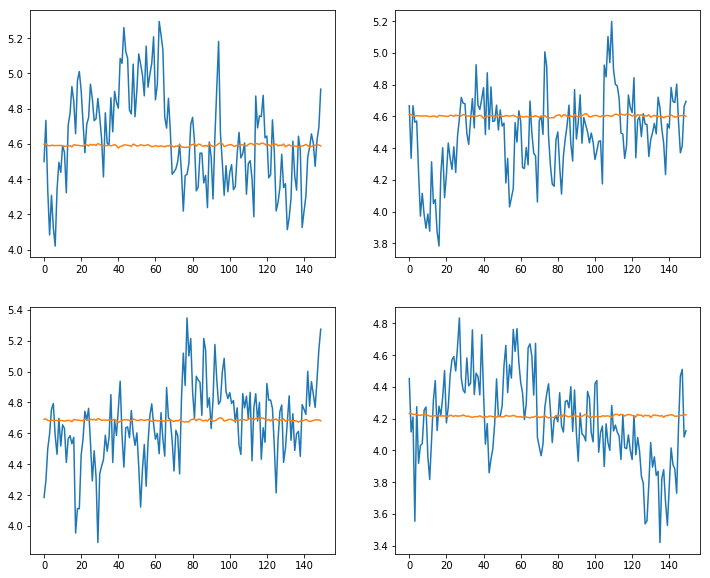

In [81]:
learnAE.show_results(DatasetType.Train,channels=[0])

In [19]:
def conv1d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False, init:LayerFunc=nn.init.kaiming_normal_) -> nn.Conv1d:
    "Create and initialize `nn.Conv1d` layer. `padding` defaults to `ks//2`."
    if padding is None: padding = ks//2
    return init_default(nn.Conv1d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias), init)

def _bn1d(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm1d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv1d(ni, nf, ks, stride, init_zero=False):
    bn_initzero = _bn1d(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv1d(ni, nf, ks, stride))

class ResBlock(torch.nn.Module):
    def __init__(self, ni, nf, stride, drop_p=0.0):
        super().__init__()
        self.bn = nn.BatchNorm1d(ni)
        self.conv1 = conv1d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv1d(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv1d(ni, nf, 1, stride) if ni != nf else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

class WideResNet1d(nn.Module):
    "Wide ResNet with `num_groups` and a width of `k`."
    def __init__(self, num_groups:int, N:int, k:int=1, n_features:int=1, drop_p:float=0.0, start_nf:int=16,maxY=20.0,):
        super().__init__()
        self.maxY = maxY
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)
        
        
        layers = [conv1d(n_features, n_channels[0], 3, 1)]  # conv1
        self.split_groups = [layers[-1]] 
        
        for i in range(num_groups):
            layers += _make_group(N, n_channels[i], n_channels[i+1], ResBlock, (1 if i==0 else 2), drop_p)
            self.split_groups.append(layers[-N])
            
        layers += [nn.BatchNorm1d(n_channels[-1]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool1d(1),
                   Flatten()]
        #self.split_groups.append(layers[-1])
        self.nf = n_channels[-1]
        self.features = nn.Sequential(*layers)

    def forward(self, x):
        return self.features(x)